Importing libraries

In [2]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

Loading Image Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/

MyDrive


In [5]:
train_dir = '/content/drive/MyDrive/Deep_learning/TRAIN'
test_dir = '/content/drive/MyDrive/Deep_learning/TEST'

Create Generators

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

Flow Image Data


In [7]:
train_images=train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


Build Pretrained Model

In [8]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Build classification model

In [9]:
inputs=pretrained_model.input
x=tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs=tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Training

In [10]:
import os

In [11]:
history=model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True)])

Epoch 1/100
249/249 [==============================] - 1660s 7s/step - loss: 0.8055 - accuracy: 0.6714 - val_loss: 0.5734 - val_accuracy: 0.7788
Epoch 2/100
249/249 [==============================] - 40s 163ms/step - loss: 0.4592 - accuracy: 0.8245 - val_loss: 0.4225 - val_accuracy: 0.8341
Epoch 3/100
249/249 [==============================] - 40s 159ms/step - loss: 0.3637 - accuracy: 0.8581 - val_loss: 0.3576 - val_accuracy: 0.8572
Epoch 4/100
249/249 [==============================] - 39s 158ms/step - loss: 0.2634 - accuracy: 0.9055 - val_loss: 0.2993 - val_accuracy: 0.8849
Epoch 5/100
249/249 [==============================] - 39s 157ms/step - loss: 0.2051 - accuracy: 0.9267 - val_loss: 0.2624 - val_accuracy: 0.9015
Epoch 6/100
249/249 [==============================] - 40s 163ms/step - loss: 0.1711 - accuracy: 0.9406 - val_loss: 0.2349 - val_accuracy: 0.9165
Epoch 7/100
249/249 [==============================] - 42s 168ms/step - loss: 0.1347 - accuracy: 0.9544 - val_loss: 0.2290 - 

In [12]:
model.save('/content/drive/MyDrive/Deep_learning/history')

In [13]:
model.save_weights('/content/drive/MyDrive/Deep_l1/history')

In [14]:
model.save_weights('/content/drive/MyDrive/Deep_l1/history.h5')

In [15]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

Results

In [16]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

78/78 [==============================] - 521s 7s/step
Test Accuracy: 52.795%


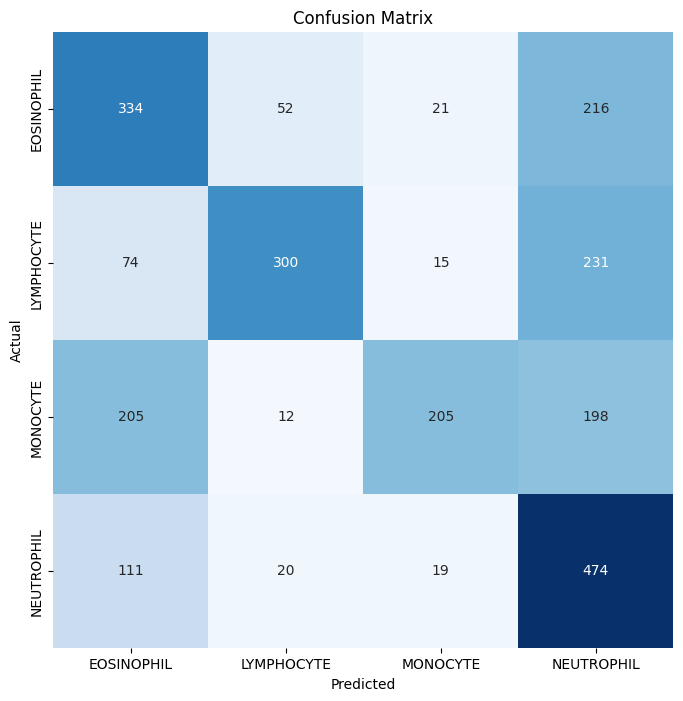

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.46      0.54      0.50       623
  LYMPHOCYTE       0.78      0.48      0.60       620
    MONOCYTE       0.79      0.33      0.47       620
  NEUTROPHIL       0.42      0.76      0.54       624

    accuracy                           0.53      2487
   macro avg       0.61      0.53      0.53      2487
weighted avg       0.61      0.53      0.53      2487



In [18]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [19]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)

Found 1989 images belonging to 4 classes.


63/63 [==============================] - 13s 204ms/step
Validation Accuracy: 95.626%


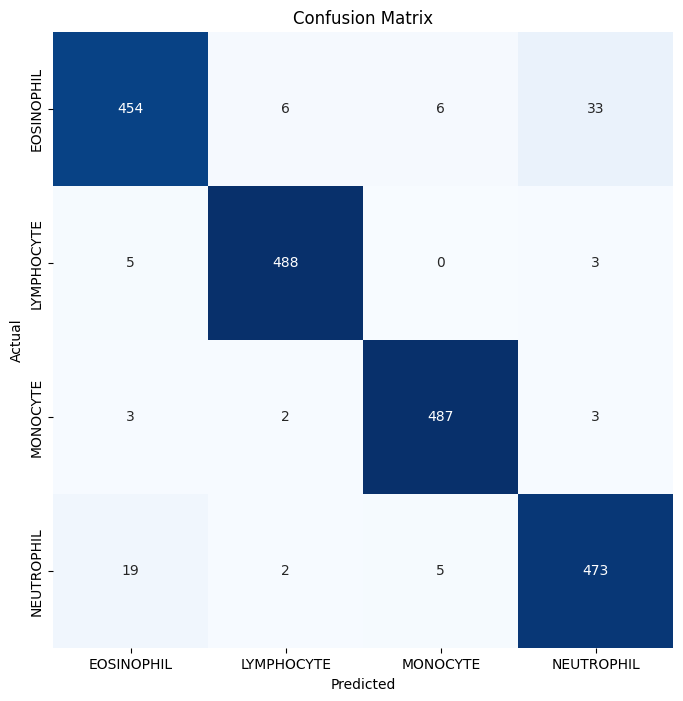

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.91      0.93       499
  LYMPHOCYTE       0.98      0.98      0.98       496
    MONOCYTE       0.98      0.98      0.98       495
  NEUTROPHIL       0.92      0.95      0.94       499

    accuracy                           0.96      1989
   macro avg       0.96      0.96      0.96      1989
weighted avg       0.96      0.96      0.96      1989



In [20]:
predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("Classification Report:\n----------------------\n", clr)

Model Deployement with Gradio

In [45]:
! pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import gradio as gr

In [47]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Deep_learning/history')

In [48]:
CLASS_NAMES_1 = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

In [53]:
def predict(image):
    probabilities = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = CLASS_NAMES[predicted_class_index]
    return predicted_class_name

In [58]:
input_image = gr.inputs.Image(shape=(224, 224))
output_text = gr.outputs.Textbox()
gr.Interface(fn=predict, inputs=input_image, outputs=output_text).launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning:

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning:

`optional` parameter is deprecated, and it has no effect

/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:22: UserWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>